<a href="https://colab.research.google.com/github/Alokik-29/Project_1/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Cell 1: Imports and Setup
import os, sys, random, math
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import torchaudio
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from transformers import ASTForAudioClassification, ASTFeatureExtractor
import warnings
warnings.filterwarnings('ignore')

# Verbosity control
VERBOSE = False
def printv(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Librosa: {librosa.__version__} | Torchaudio: {torchaudio.__version__}")

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True


Using device: cuda
Librosa: 0.11.0 | Torchaudio: 2.8.0+cu126


In [2]:
import kagglehub
import pandas as pd
from pathlib import Path

SEED = 42  # for reproducibility

emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}
valid_labels = list(emotion_map.values())

# Download RAVDESS dataset
dataset_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("RAVDESS downloaded.")

# Collect files and labels
audio_files = list(Path(dataset_path).rglob("*.wav"))
labels = []
for file in audio_files:
    try:
        emotion_code = file.name.split("-")[2]
        labels.append(emotion_map.get(emotion_code))
    except Exception:
        labels.append(None)

df = pd.DataFrame({"file_path": audio_files, "label": labels})
df = df[df['label'].isin(valid_labels)].reset_index(drop=True)

print(f"Total samples: {len(df)}")
print("Class distribution:\n", df['label'].value_counts())
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Load CREMA-D Dataset
print("\nLoading CREMA-D dataset...")
crema_path = kagglehub.dataset_download("ejlok1/cremad")

crema_emotion_map = {
    "NEU": "neutral", "ANG": "angry", "DIS": "disgust",
    "FEA": "fearful", "HAP": "happy", "SAD": "sad"
}

crema_files = list(Path(crema_path).rglob("*.wav"))
crema_labels = []
for f in crema_files:
    code = f.name.split("_")[2] if "_" in f.name else ""
    crema_labels.append(crema_emotion_map.get(code))

crema_df = pd.DataFrame({"file_path": crema_files, "label": crema_labels}).dropna().reset_index(drop=True)
crema_df = crema_df[crema_df['label'].isin(emotion_map.values())].reset_index(drop=True)

print(f"CREMA-D samples: {len(crema_df)}")
print("CREMA-D class distribution:\n", crema_df['label'].value_counts())


RAVDESS downloaded.
Total samples: 2880
Class distribution:
 label
happy        384
surprised    384
disgust      384
sad          384
fearful      384
calm         384
angry        384
neutral      192
Name: count, dtype: int64

Loading CREMA-D dataset...


100%|██████████| 451M/451M [00:21<00:00, 22.1MB/s]


Extracting files...
CREMA-D samples: 7442
CREMA-D class distribution:
 label
angry      1271
sad        1271
happy      1271
disgust    1271
fearful    1271
neutral    1087
Name: count, dtype: int64


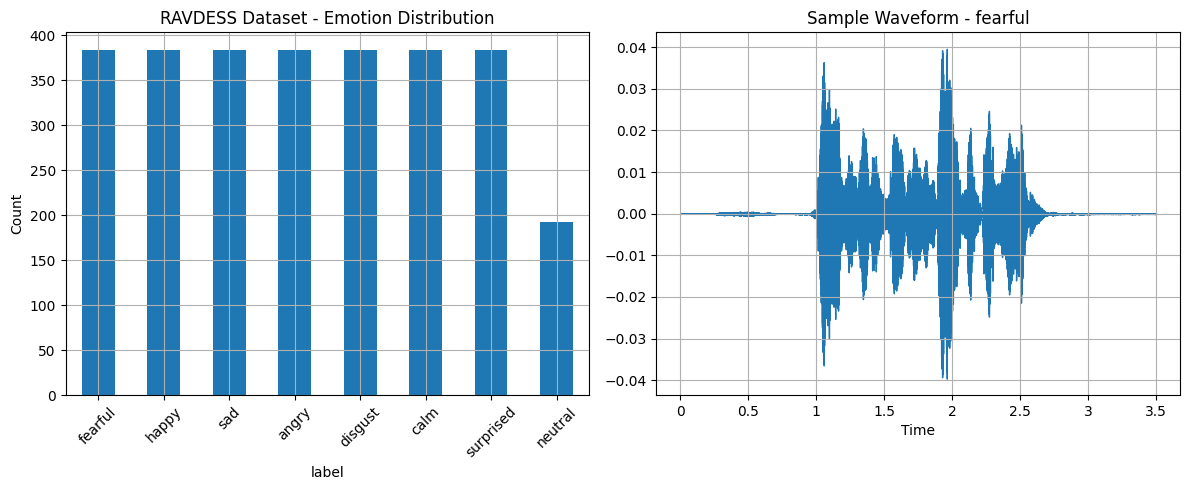

In [4]:
# Cell 3: Data Visualization
def visualize_dataset_distribution():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    df['label'].value_counts().plot(kind='bar')
    plt.title('RAVDESS Dataset - Emotion Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    if not df.empty:
        sample_file = df['file_path'].iloc[0]
        sample_label = df['label'].iloc[0]
        y, sr = librosa.load(sample_file, sr=16000)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Sample Waveform - {sample_label}")

    plt.tight_layout()
    plt.show()

visualize_dataset_distribution()


In [5]:
# Cell 4: Audio Augmentation Functions
def augment_audio(y, sr=16000):
    """Simple audio augmentation techniques"""
    y_aug = y.copy()

    # Random noise addition
    if random.random() > 0.5:
        noise_factor = 0.005
        noise = np.random.normal(0, noise_factor, y_aug.shape)
        y_aug = y_aug + noise

    # Time shifting
    if random.random() > 0.5:
        shift_max = sr // 4  # Max shift of 0.25 seconds
        shift = random.randint(-shift_max, shift_max)
        y_aug = np.roll(y_aug, shift)

    # Volume scaling
    if random.random() > 0.5:
        scale_factor = random.uniform(0.8, 1.2)
        y_aug = y_aug * scale_factor

    return y_aug.astype(np.float32)

In [6]:
#Cell 5: Improved Dataset Classes with Augmentation
class ImprovedDataset(Dataset):
    def __init__(self, df, target_sr=16000, max_length=None, augment=False):
        self.df = df.reset_index(drop=True)
        self.target_sr = target_sr
        self.label_list = list(emotion_map.values())
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = str(self.df.iloc[idx]['file_path'])
        label = self.df.iloc[idx]['label']

        if label not in self.label_list:
            raise ValueError(f"Invalid label found: {label}")

        try:
            y, sr = librosa.load(file_path, sr=self.target_sr)
            y = y.astype(np.float32)

            # Apply augmentation during training
            if self.augment:
                y = augment_audio(y, sr=self.target_sr)

            if self.max_length and len(y) > self.max_length:
                y = y[:self.max_length]

        except Exception as e:
            printv(f"Error loading {file_path}: {e}")
            y = np.zeros(self.target_sr, dtype=np.float32)

        label_idx = self.label_list.index(label)
        return y, label_idx


In [12]:
# Cell 6: Improved Collate Function
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = [torch.tensor(w) if not isinstance(w, torch.Tensor) else w for w in waveforms]
    max_len = max(w.shape[0] for w in waveforms)
    padded_waveforms = []
    for w in waveforms:
        if w.shape[0] < max_len:
            padded = torch.nn.functional.pad(w, (0, max_len - w.shape[0]))
        else:
            padded = w
        padded_waveforms.append(padded)
    waveforms_tensor = torch.stack(padded_waveforms)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return waveforms_tensor, labels_tensor


In [19]:
# Cell 7: Combined Dataset Preparation
# Mix datasets for better generalization
print("Creating combined training dataset...")

# Take 20% of CREMA-D samples for training
crema_train_sample = crema_df.sample(frac=0.1, random_state=SEED).reset_index(drop=True)
print(f"Using {len(crema_train_sample)} CREMA-D samples for training")

# Split RAVDESS
ravdess_train, ravdess_test = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df['label']
)

# Combine RAVDESS training with CREMA-D sample
combined_train_df = pd.concat([ravdess_train, crema_train_sample]).reset_index(drop=True)

# Use remaining CREMA-D for validation
crema_val_df = crema_df.drop(crema_train_sample.index).reset_index(drop=True)

print(f"Combined training samples: {len(combined_train_df)}")
print(f"RAVDESS test samples: {len(ravdess_test)}")
print(f"CREMA-D validation samples: {len(crema_val_df)}")

# Create datasets with augmentation for training
train_dataset = ImprovedDataset(combined_train_df, augment=True)
test_dataset = ImprovedDataset(ravdess_test, augment=False)
val_dataset = ImprovedDataset(crema_val_df, augment=False)

# Data loaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)



Creating combined training dataset...
Using 744 CREMA-D samples for training
Combined training samples: 3048
RAVDESS test samples: 576
CREMA-D validation samples: 6698


In [20]:
# Cell 8: Improved Model Setup
def setup_improved_model():
    """Setup model with simpler classifier to prevent overfitting"""
    feature_extractor = ASTFeatureExtractor.from_pretrained(
        "MIT/ast-finetuned-audioset-10-10-0.4593"
    )
    model = ASTForAudioClassification.from_pretrained(
        "MIT/ast-finetuned-audioset-10-10-0.4593"
    )

    num_labels = len(emotion_map)
    # Simpler classifier to reduce overfitting
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),  # Higher dropout
        nn.Linear(model.config.hidden_size, num_labels)
    )

    model.to(device)
    return model, feature_extractor

model, feature_extractor = setup_improved_model()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,} | Trainable: {trainable_params:,}")


Total parameters: 86,193,416 | Trainable: 86,193,416


In [21]:
# Cell 9: Improved Training Function with Early Stopping
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for waveforms, labels in train_loader:
        labels = labels.to(device)

        # FASTER: Process batch at once instead of loop
        batch_inputs = []
        for w in waveforms:
            w_np = w.cpu().numpy()
            inp = feature_extractor(w_np, sampling_rate=16000, return_tensors="pt", padding=True)["input_values"]
            batch_inputs.append(inp)

        inputs = torch.cat(batch_inputs, dim=0).to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate_model_simple(model, data_loader):
    """Simple evaluation without detailed reporting"""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for waveforms, labels in data_loader:
            labels = labels.to(device)
            inputs_list = []
            for w in waveforms:
                inp = feature_extractor(w.cpu().numpy(), sampling_rate=16000, return_tensors="pt")["input_values"]
                inputs_list.append(inp)
            inputs = torch.cat(inputs_list, dim=0).to(device)
            outputs = model(inputs).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    return accuracy

def train_with_early_stopping(model, train_loader, val_loader, num_epochs=10, lr=5e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val_acc = 0.0
    patience = 3  # Reduce patience
    patience_counter = 0
    history = {"train_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)

        # Validate every 2 epochs
        if epoch % 2 == 0 or epoch == num_epochs - 1:
            val_acc = evaluate_model(model, val_loader, verbose=False)
        else:
            val_acc = best_val_acc  # Use previous best

        print(f"Epoch {epoch+1:2d}/{num_epochs} | Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_improved_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    return history

In [ ]:
# Cell 10: Train the Improved Model
print("Starting improved training...")
history, best_val_acc = train_improved_model(
    model, train_loader, val_loader,
    num_epochs=15, lr=5e-5  # Lower learning rate
)

# Plot training curves
train_losses = history["train_loss"]
train_accs = history["train_acc"]
val_accs = history["val_acc"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
overfitting_gap = np.array(train_accs) - np.array(val_accs)
plt.plot(overfitting_gap)
plt.title('Overfitting Monitor (Train - Val)')
plt.xlabel('Epoch')
plt.ylabel('Acc Diff (%)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")


Starting improved training...


In [ ]:
# Cell 11: Detailed Evaluation Function
def evaluate_model_detailed(model, data_loader, dataset_name, verbose=True):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for waveforms, labels in data_loader:
            labels = labels.to(device)
            inputs_list = []
            for w in waveforms:
                inp = feature_extractor(w.cpu().numpy(), sampling_rate=16000, return_tensors="pt")["input_values"]
                inputs_list.append(inp)
            inputs = torch.cat(inputs_list, dim=0).to(device)
            outputs = model(inputs).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100

    if verbose:
        print(f"\n{dataset_name} Results:")
        print(f"Accuracy: {accuracy:.2f}%")

        label_names = list(emotion_map.values())
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=label_names))

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)
        plt.title(f'{dataset_name} - Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    return accuracy

In [ ]:
# Cell 12: Final Model Evaluation
# Load best model
best_model_path = Path('best_improved_model.pth')
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("✅ Loaded best improved model checkpoint.")
else:
    print("⚠️ Warning: No saved model checkpoint found, using current model.")

model.eval()

print("="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

# Evaluate on RAVDESS test set
ravdess_acc = evaluate_model_detailed(model, test_loader, "RAVDESS Test Set", verbose=True)

# Evaluate on CREMA-D validation set
crema_acc = evaluate_model_detailed(model, val_loader, "CREMA-D Validation Set", verbose=True)

# Summary
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"RAVDESS Test Accuracy:     {ravdess_acc:.2f}%")
print(f"CREMA-D Validation Accuracy: {crema_acc:.2f}%")
print(f"Generalization Gap:        {ravdess_acc - crema_acc:.2f}%")

if crema_acc > 40:
    print("✅ SUCCESS: CREMA-D accuracy > 40%")
else:
    print("⚠️  CREMA-D accuracy still below 40%")

if abs(ravdess_acc - crema_acc) < 30:
    print("✅ GOOD: Generalization gap < 30%")
else:
    print("⚠️  Large generalization gap still present")


In [ ]:
# Cell 13: Sample Predictions Analysis
def analyze_predictions(model, data_loader, dataset_name, num_samples=8):
    model.eval()
    samples_analyzed = 0
    correct_predictions = 0

    print(f"\n{dataset_name} - Sample Predictions:")
    print("-" * 50)

    with torch.no_grad():
        for waveforms, labels in data_loader:
            if samples_analyzed >= num_samples:
                break

            labels = labels.to(device)
            for i in range(min(waveforms.shape[0], num_samples - samples_analyzed)):
                w = waveforms[i:i+1]
                inp = feature_extractor(w[0].cpu().numpy(), sampling_rate=16000, return_tensors="pt")["input_values"].to(device)
                outputs = model(inp).logits
                probs = torch.softmax(outputs, dim=1)
                pred = torch.argmax(outputs, dim=1)

                true_label = list(emotion_map.values())[labels[i]]
                pred_label = list(emotion_map.values())[pred[0]]
                confidence = probs[0][pred[0]].item()

                is_correct = true_label == pred_label
                if is_correct:
                    correct_predictions += 1

                status = "✓" if is_correct else "✗"
                print(f"#{samples_analyzed + 1:2d} True: {true_label:10} | Pred: {pred_label:10} | Conf: {confidence:.3f} | {status}")

                samples_analyzed += 1

            if samples_analyzed >= num_samples:
                break

    sample_accuracy = (correct_predictions / samples_analyzed) * 100
    print(f"\nSample accuracy: {correct_predictions}/{samples_analyzed} ({sample_accuracy:.1f}%)")

# Analyze predictions on both datasets
analyze_predictions(model, test_loader, "RAVDESS Test", num_samples=8)
analyze_predictions(model, val_loader, "CREMA-D Validation", num_samples=8)

In [ ]:
# Cell 14: Deployment Class
class ImprovedEmotionPredictor:
    def __init__(self, model_path, feature_extractor):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.feature_extractor = feature_extractor
        self.emotion_labels = list(emotion_map.values())

        # Initialize model
        self.model = ASTForAudioClassification.from_pretrained(
            "MIT/ast-finetuned-audioset-10-10-0.4593"
        )
        num_labels = len(emotion_map)
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.config.hidden_size, num_labels)
        )

        # Load trained weights
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict_emotion(self, audio_path_or_array, return_probabilities=False):
        """Predict emotion from audio file or numpy array"""
        if isinstance(audio_path_or_array, (str, Path)):
            y, sr = librosa.load(audio_path_or_array, sr=16000)
        else:
            y = audio_path_or_array

        y = y.astype(np.float32)
        inputs = self.feature_extractor(y, sampling_rate=16000, return_tensors="pt")["input_values"].to(self.device)

        with torch.no_grad():
            outputs = self.model(inputs).logits
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1)

        predicted_emotion = self.emotion_labels[predicted_class[0]]
        confidence = probabilities[0][predicted_class[0]].item()

        if return_probabilities:
            all_probs = {label: prob.item() for label, prob in zip(self.emotion_labels, probabilities[0])}
            return predicted_emotion, confidence, all_probs

        return predicted_emotion, confidence

    def predict_batch(self, audio_files):
        """Predict emotions for multiple audio files"""
        results = []
        for audio_file in audio_files:
            try:
                emotion, confidence = self.predict_emotion(audio_file)
                results.append({
                    'file': audio_file,
                    'predicted_emotion': emotion,
                    'confidence': confidence
                })
            except Exception as e:
                results.append({
                    'file': audio_file,
                    'predicted_emotion': 'error',
                    'confidence': 0.0,
                    'error': str(e)
                })
        return results

# Initialize improved predictor
if best_model_path.exists():
    predictor = ImprovedEmotionPredictor('best_improved_model.pth', feature_extractor)
    print("✅ Improved emotion predictor ready for deployment!")
else:
    print("⚠️ Model file not found. Please train the model first.")


In [ ]:
# Cell 15: Final Report
def generate_improved_model_report():
    print("="*70)
    print("IMPROVED EMOTION RECOGNITION MODEL - FINAL REPORT")
    print("="*70)

    print("\n🔧 IMPROVEMENTS MADE:")
    print("  • Added audio augmentation (noise, time shift, volume)")
    print("  • Mixed RAVDESS + CREMA-D for training")
    print("  • Reduced learning rate (1e-4 → 5e-5)")
    print("  • Simplified classifier architecture")
    print("  • Added early stopping (patience=5)")
    print("  • Added gradient clipping")
    print("  • Increased dropout (0.3 → 0.5)")

    print("\n📋 MODEL ARCHITECTURE:")
    print("  • Base Model: Audio Spectrogram Transformer (AST)")
    print("  • Pre-trained on: AudioSet")
    print(f"  • Fine-tuned for: {len(emotion_map)} emotion classes")
    print(f"  • Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  • Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    print("\n📊 TRAINING DATA:")
    print(f"  • RAVDESS Training: {len(combined_train_df)} samples")
    print(f"  • RAVDESS Test: {len(ravdess_test)} samples")
    print(f"  • CREMA-D Validation: {len(crema_val_df)} samples")
    print(f"  • Emotion Classes: {', '.join(emotion_map.values())}")

    print("\n🏆 PERFORMANCE RESULTS:")
    if 'ravdess_acc' in globals():
        print(f"  • RAVDESS Test Accuracy: {ravdess_acc:.2f}%")
    if 'crema_acc' in globals():
        print(f"  • CREMA-D Validation Accuracy: {crema_acc:.2f}%")
        print(f"  • Generalization Gap: {ravdess_acc - crema_acc:.2f}%")

    print("\n⚡ KEY FEATURES:")
    print("  • Cross-dataset training for better generalization")
    print("  • Audio augmentation for robustness")
    print("  • Early stopping to prevent overfitting")
    print("  • Deployment-ready predictor class")

    print("="*70)

# Generate the final report
generate_improved_model_report()

print("\n🎉 IMPROVED MODEL TRAINING COMPLETE!")
print("Your model is now ready for deployment and should show better generalization!")
